In [1]:
!pip install normflows

In [ ]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 9.0 MB/s eta 0:00:00


In [2]:
import torch
import normflows as nf


import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import json
import torch
import torch.nn as nn
from torch import Tensor
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from tqdm import tqdm
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import gc

## Generating Text-Image Dataset

A dataset of $(x,y)$ pairs where $x$ is a string of numbers and $y$ is a black and white image displaying those numbers

In [3]:
# @title Dataset Generation Definition
class NumberImageDataset(Dataset):
    """Dataset of number strings and their corresponding images (white text on black background)."""

    def __init__(self, num_samples=1000, min_length=3, max_length=6,
                 image_width=280, image_height=120,
                 transform=None, return_text=True,
                 consecutive_digits:bool=False):
        """Initialize the dataset."""
        self.num_samples = num_samples
        self.min_length = min_length
        self.max_length = max_length
        self.image_width = image_width
        self.image_height = image_height
        self.transform = transform
        self.return_text = return_text
        self.consecutive_digits = consecutive_digits
        # Generate number strings
        self.number_strings = [
            self._generate_number_string() for _ in range(num_samples)
        ]

    def _generate_number_string(self):
        """Generate a random string of numbers with length between min_length and max_length."""
        length = random.randint(self.min_length, self.max_length)
        if self.consecutive_digits:
            start_digit = random.randint(0, 9)
            result = str(start_digit)
            for _ in range(length - 1):
                next_digit = (start_digit + 1) % 10
                result += str(next_digit)
                start_digit = next_digit
        else:
            result = ''.join(random.choices('0123456789', k=length))
        return result

    def _create_number_image(self, number_string):
        """Create an image with the number_string displayed in white on black background."""
        # Create a black background
        img_array = np.zeros((self.image_height, self.image_width, 3), dtype=np.uint8)

        # Number of characters in the string
        num_chars = len(number_string)

        # Width available for each character (including margins)
        char_width = self.image_width // num_chars

        # Height of the characters (80% of image height)
        char_height = int(self.image_height * 0.8)

        # For each digit in the number
        for i, digit in enumerate(number_string):
            # Calculate the position for this digit
            x_start = i * char_width
            x_end = (i + 1) * char_width
            y_center = self.image_height // 2

            # Size of the digit rectangle (80% of available space)
            rect_width = min(int(char_width * 0.8), char_height)
            x_left = x_start + (char_width - rect_width) // 2
            y_top = y_center - rect_width // 2

            # Thickness of the segments (20% of digit size but minimum 2px)
            thickness = max(rect_width // 5, 2)

            # Draw the digit
            if digit == '0':
                # Draw a rectangle with a hole
                # Top horizontal
                img_array[y_top:y_top+thickness, x_left:x_left+rect_width] = 255
                # Bottom horizontal
                img_array[y_top+rect_width-thickness:y_top+rect_width, x_left:x_left+rect_width] = 255
                # Left vertical
                img_array[y_top:y_top+rect_width, x_left:x_left+thickness] = 255
                # Right vertical
                img_array[y_top:y_top+rect_width, x_left+rect_width-thickness:x_left+rect_width] = 255

            elif digit == '1':
                # Draw a vertical line (center-right)
                x_center = x_left + rect_width - thickness
                img_array[y_top:y_top+rect_width, x_center:x_center+thickness] = 255

            elif digit == '2':
                # Top horizontal
                img_array[y_top:y_top+thickness, x_left:x_left+rect_width] = 255
                # Middle horizontal
                middle_y = y_top + rect_width // 2
                img_array[middle_y:middle_y+thickness, x_left:x_left+rect_width] = 255
                # Bottom horizontal
                img_array[y_top+rect_width-thickness:y_top+rect_width, x_left:x_left+rect_width] = 255
                # Top-right vertical
                img_array[y_top:middle_y, x_left+rect_width-thickness:x_left+rect_width] = 255
                # Bottom-left vertical
                img_array[middle_y:y_top+rect_width, x_left:x_left+thickness] = 255

            elif digit == '3':
                # Top horizontal
                img_array[y_top:y_top+thickness, x_left:x_left+rect_width] = 255
                # Middle horizontal
                middle_y = y_top + rect_width // 2
                img_array[middle_y:middle_y+thickness, x_left:x_left+rect_width] = 255
                # Bottom horizontal
                img_array[y_top+rect_width-thickness:y_top+rect_width, x_left:x_left+rect_width] = 255
                # Right vertical
                img_array[y_top:y_top+rect_width, x_left+rect_width-thickness:x_left+rect_width] = 255

            elif digit == '4':
                # Middle horizontal
                middle_y = y_top + rect_width // 2
                img_array[middle_y:middle_y+thickness, x_left:x_left+rect_width] = 255
                # Top-left vertical
                img_array[y_top:middle_y+thickness, x_left:x_left+thickness] = 255
                # Right vertical
                img_array[y_top:y_top+rect_width, x_left+rect_width-thickness:x_left+rect_width] = 255

            elif digit == '5':
                # Top horizontal
                img_array[y_top:y_top+thickness, x_left:x_left+rect_width] = 255
                # Middle horizontal
                middle_y = y_top + rect_width // 2
                img_array[middle_y:middle_y+thickness, x_left:x_left+rect_width] = 255
                # Bottom horizontal
                img_array[y_top+rect_width-thickness:y_top+rect_width, x_left:x_left+rect_width] = 255
                # Top-left vertical
                img_array[y_top:middle_y, x_left:x_left+thickness] = 255
                # Bottom-right vertical
                img_array[middle_y:y_top+rect_width, x_left+rect_width-thickness:x_left+rect_width] = 255

            elif digit == '6':
                # Top horizontal
                img_array[y_top:y_top+thickness, x_left:x_left+rect_width] = 255
                # Middle horizontal
                middle_y = y_top + rect_width // 2
                img_array[middle_y:middle_y+thickness, x_left:x_left+rect_width] = 255
                # Bottom horizontal
                img_array[y_top+rect_width-thickness:y_top+rect_width, x_left:x_left+rect_width] = 255
                # Left vertical
                img_array[y_top:y_top+rect_width, x_left:x_left+thickness] = 255
                # Bottom-right vertical
                img_array[middle_y:y_top+rect_width, x_left+rect_width-thickness:x_left+rect_width] = 255

            elif digit == '7':
                # Top horizontal
                img_array[y_top:y_top+thickness, x_left:x_left+rect_width] = 255
                # Right vertical
                img_array[y_top:y_top+rect_width, x_left+rect_width-thickness:x_left+rect_width] = 255

            elif digit == '8':
                # Top horizontal
                img_array[y_top:y_top+thickness, x_left:x_left+rect_width] = 255
                # Middle horizontal
                middle_y = y_top + rect_width // 2
                img_array[middle_y:middle_y+thickness, x_left:x_left+rect_width] = 255
                # Bottom horizontal
                img_array[y_top+rect_width-thickness:y_top+rect_width, x_left:x_left+rect_width] = 255
                # Left vertical
                img_array[y_top:y_top+rect_width, x_left:x_left+thickness] = 255
                # Right vertical
                img_array[y_top:y_top+rect_width, x_left+rect_width-thickness:x_left+rect_width] = 255

            elif digit == '9':
                # Top horizontal
                img_array[y_top:y_top+thickness, x_left:x_left+rect_width] = 255
                # Middle horizontal
                middle_y = y_top + rect_width // 2
                img_array[middle_y:middle_y+thickness, x_left:x_left+rect_width] = 255
                # Bottom horizontal
                img_array[y_top+rect_width-thickness:y_top+rect_width, x_left:x_left+rect_width] = 255
                # Top-left vertical
                img_array[y_top:middle_y, x_left:x_left+thickness] = 255
                # Right vertical
                img_array[y_top:y_top+rect_width, x_left+rect_width-thickness:x_left+rect_width] = 255

        return (img_array * np.random.uniform(0.7, 1, (self.image_height, self.image_width, 3)) + np.random.uniform(0, 0.3 * 255, (self.image_height, self.image_width, 3))).clip(0, 255).astype(np.uint8)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Get the number string
        number_string = self.number_strings[idx]

        # Create the image
        image = self._create_number_image(number_string)

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)
        else:
            # Default transform to convert to tensor
            image = transforms.ToTensor()(image)

        image = image * 255

        # Return image and label
        if self.return_text:
            return image, number_string
        else:
            return image

def create_number_image_dataloader(
    num_samples=1000,
    batch_size=32,
    min_length=3,
    max_length=6,
    image_width=64,
    image_height=64,
    num_workers=1,
    shuffle=True,
    transform=None,
    return_text=True,
    consecutive_digits=False
):
    """
    Create a DataLoader for number-image pairs. The text will span most of the image width.
    """
    # Define default transforms if none provided
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

    # Create dataset
    dataset = NumberImageDataset(
        num_samples=num_samples,
        min_length=min_length,
        max_length=max_length,
        image_width=image_width,
        image_height=image_height,
        transform=transform,
        return_text=return_text,
        consecutive_digits=consecutive_digits
    )

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )

    return dataloader


In [4]:
# @title
SIZE=64
dataset = create_number_image_dataloader(num_samples=100_000, batch_size=16, image_width=SIZE, image_height=SIZE)

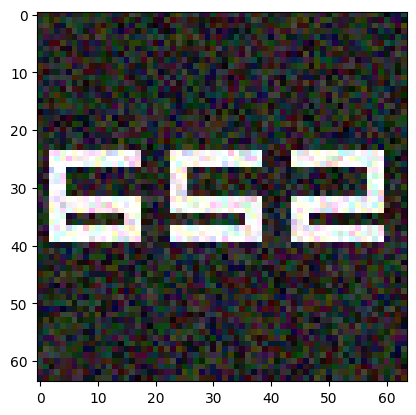

In [5]:
# @title Visualize entry in dataset
X, Y = next(iter(dataset))
x = np.array(X[0])
x = np.swapaxes(x, 0, 2)
x = np.swapaxes(x, 0,1)
plt.imshow(x.astype(np.uint8))

## Normalizing Flow Component

definition, and training example

In [6]:
# @title Normalizing Flow Affine Blocks
from normflows.flows import Split, Merge, Flow
class AffineCoupling(nf.flows.Flow):
    """
    Affine Coupling layer as introduced RealNVP paper, see arXiv: 1605.08803
    """

    def __init__(self, param_map, scale=True, scale_map="exp"):
        """Constructor

        Args:
          param_map: Maps features to shift and scale parameter (if applicable)
          scale: Flag whether scale shall be applied
          scale_map: Map to be applied to the scale parameter, can be 'exp' as in RealNVP or 'sigmoid' as in Glow, 'sigmoid_inv' uses multiplicative sigmoid scale when sampling from the model
        """
        super().__init__()
        self.add_module("param_map", param_map)
        self.scale = scale
        self.scale_map = scale_map
        self.first = False

    def forward(self, z):
        """
        z is a list of z1 and z2; ```z = [z1, z2]```
        z1 is left constant and affine map is applied to z2 with parameters depending
        on z1

        Args:
          z
        """
        z1, z2 = z
        param = self.param_map(z1)
        if self.scale:
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            if self.scale_map == "exp":
                z2 = z2 * torch.exp(scale_) + shift
                log_det = torch.sum(scale_, dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid":
                scale = torch.sigmoid(scale_ + 2)
                z2 = z2 / scale + shift
                log_det = -torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid_inv":
                scale = torch.sigmoid(scale_ + 2)
                z2 = z2 * scale + shift
                log_det = torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            elif self.scale_map == 'jet':
                z2 = (z2 + shift) * torch.sigmoid(scale_) * 2
                log_det = torch.sum(torch.log(torch.sigmoid(scale_) * 2), dim=list(range(1, shift.dim())))
            else:
                raise NotImplementedError("This scale map is not implemented.")
        else:
            z2 = z2 + param
            log_det = nf.base.zero_log_det_like_z(z2)
        return [z1, z2], log_det

    def inverse(self, z):
        z1, z2 = z
        param = self.param_map(z1)
        if self.scale:
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            if self.scale_map == "exp":
                z2 = (z2 - shift) * torch.exp(-scale_)
                log_det = -torch.sum(scale_, dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid":
                scale = torch.sigmoid(scale_ + 2)
                z2 = (z2 - shift) * scale
                log_det = torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid_inv":
                scale = torch.sigmoid(scale_ + 2)
                z2 = (z2 - shift) / scale
                log_det = -torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            elif self.scale_map == 'jet':
                if self.first:
                    print(shift, scale_)
                    self.first = False
                z2 = z2 / (torch.sigmoid(scale_) * 2) - shift
                log_det = -torch.sum(torch.log(torch.sigmoid(scale_) * 2), dim=list(range(1, shift.dim())))
            else:
                raise NotImplementedError("This scale map is not implemented.")
        else:
            z2 = z2 - param
            log_det = nf.zero_log_det_like_z(z2)
        return [z1, z2], log_det


class AffineCouplingBlock(Flow):
    """
    Affine Coupling layer including split and merge operation
    """

    def __init__(self, param_map, scale=True, scale_map="exp", split_mode="channel"):
        """Constructor

        Args:
          param_map: Maps features to shift and scale parameter (if applicable)
          scale: Flag whether scale shall be applied
          scale_map: Map to be applied to the scale parameter, can be 'exp' as in RealNVP or 'sigmoid' as in Glow
          split_mode: Splitting mode, for possible values see Split class
        """
        super().__init__()
        self.flows = nn.ModuleList([])
        # Split layer

        self.flows += [
            Split(split_mode),
            ]
        # Affine coupling layer
        self.flows += [AffineCoupling(param_map, scale, scale_map)]
        # Merge layer
        self.flows += [Merge(split_mode)]

    def forward(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_tot += log_det
        return z, log_det_tot

    def inverse(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_det_tot += log_det
        return z, log_det_tot

In [7]:
# @title VIT Definition and Flow Generation Function
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads

        self.norm = nn.LayerNorm(dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=heads,
            batch_first=True
        )

    def forward(self, x):
        x = self.norm(x)
        out, _ = self.attention(x, x, x)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads),
                FeedForward(dim, mlp_dim)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class SimpleViT(nn.Module):
    def __init__(self,  image_width, image_height, patch_size, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()

        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        patch_dim = channels * patch_height * patch_width
        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_width, p2 = patch_height),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, patch_dim),
            nn.LayerNorm(patch_dim),
        )
        self.pos_embedding = posemb_sincos_2d(
            h = image_height // patch_height,
            w = image_width // patch_width,
            dim = patch_dim,
        )
        self.final_linear = nn.Linear(patch_dim, patch_dim)
        self.final_linear.weight.data.zero_()
        self.final_linear.bias.data.zero_()
        self.transformer = Transformer(patch_dim, depth, heads, patch_dim, patch_dim)
        self.unpatchify = nn.Sequential(Rearrange("b (h w) (p1 p2 c) -> b c (h p1) (w p2)", p1=patch_width, p2=patch_height, h=image_height // patch_width, w=image_width // patch_height),)
        self.first = True

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)
        x = self.transformer(x)
        x = self.final_linear(x)
        x = self.unpatchify(x)
        return x

def make_flows(image_width=64, image_height=64, patch_size=16, dim=512, depth=4, heads=4, mlp_dim=512, channels=1, dim_head=64, num_layers = 32):
      # Define list of flows
      flows = []
      for i in range(num_layers):
          # Neural network with two hidden layers having 64 units each
          # Last layer is initialized by zeros making training more stable
          param_map = SimpleViT(image_width, image_height, patch_size, dim, depth, heads, mlp_dim, channels-1, dim_head)
          # Add flow layer
          flows.append(AffineCouplingBlock(param_map, scale_map='jet'))
          # Swap dimensions
          flows.append(nf.flows.Permute(channels, mode='swap'))
      return flows

def make_flow_model(image_width=64, image_height=64, patch_size=4, dim=16**2*3, depth=4, heads=4, mlp_dim=16**2*3, channels=3, dim_head=64, num_layers=16):
      # Define 2D Gaussian base distribution
      base = nf.distributions.base.DiagGaussian(shape=(channels, image_height, image_width))
      flows = make_flows(image_width,
               image_height,
               patch_size,
               dim,
               depth,
               heads,
               mlp_dim,
               channels,
               dim_head,
               num_layers)

      # Construct flow model
      return nf.NormalizingFlow(base, flows)


In [8]:
flow = make_flow_model()
gc.collect()
torch.cuda.empty_cache()
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
flow = flow.to(device)

6250
cosine
tensor([-17479.3867, -17506.1172, -17440.3008, -17488.1484, -17460.5410,
        -17413.3086, -17390.0508, -17421.1523, -17385.9062, -17486.7148],
       device='cuda:0', grad_fn=<SubBackward0>)
Epoch [0/20]


  1%|          | 60/6250 [00:16<28:35,  3.61it/s, loss=tensor(29342816., device='cuda:0', grad_fn=<NegBackward0>)]


KeyboardInterrupt: 

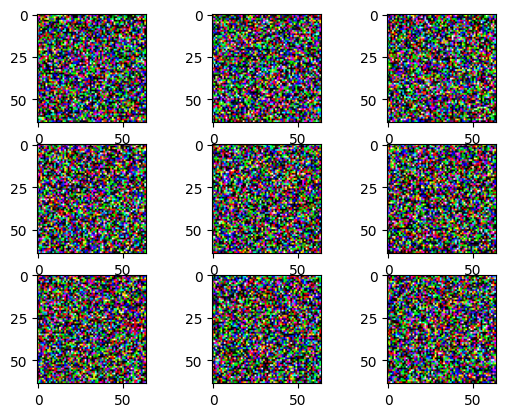

In [16]:
# Train model
epochs = 20
num_samples = 2 ** 9
show_iter = 500
total_steps = len(dataset)*epochs
print(len(dataset))
initial_noise = 0.0
t_ = 0

noise_schedules = {
    #'step': lambda t: 0.3 if t < total_steps//2 else 0, # Step,
    'cosine': lambda t: initial_noise * (1 + np.cos(t*np.pi))/2,  # Cosine
    'linear': lambda t: 0.3*(total_steps-t),  # Linear
    'logistic': lambda t: 1 / (1 + math.exp(10 * (t / total_steps - 0.5)))  # Logistic
}

for sched_key in noise_schedules.keys():
    gc.collect()
    print(sched_key)
    sched = noise_schedules[sched_key]

    flow = make_flow_model()

    torch.cuda.empty_cache()


    # Move model on GPU if available
    enable_cuda = True
    device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')


    #weights = torch.load("model_no_noise.pt", weights_only=True)
    #flow.load_state_dict(weights)
    flow = flow.to(device)


    x,lp = flow.sample(10)
    print(lp)
    #x = np.clip(rearrange(x[1], 'c h w -> h w c').detach().cpu().numpy(), 0., 1.)
    fig, ax = plt.subplots(3, 3)
    for i in range(9):
        x_i = np.clip(rearrange(x[i], 'c h w -> h w c').detach().cpu().numpy(), 0., 1.)
        ax[i//3, i%3].imshow(x_i)
    plt.savefig("samples.png")

    loss_hist = np.array([])

    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-5, weight_decay=1e-5)

    schedule = sched
    t_ =0
    #noise_schedule = lambda t: initial_noise * (1 + np.cos(t*np.pi))/2  # Cosine
    #noise_schedule = lambda t: 0.3*(total_steps-t)  # Linear
    #noise_schedule = lambda t: 1 / (1 + math.exp(10 * (t / total_steps - 0.5)))  # Logistic

    for e in range(epochs):
        print("Epoch [{}/{}]".format(e, epochs))
        with tqdm(dataset) as tp:
            for x, y in tp:
                optimizer.zero_grad()

                # Get training samples
                x = x.to(device)
                noise_at_t = initial_noise * (1 + np.cos(t_*np.pi))/2
                # Compute loss
                x = x + sched(t_)*torch.randn_like(x).to(device)
                loss = flow.forward_kld(x)

                # Do backprop and optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()

                # Log loss
                loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
                tp.set_postfix(loss=loss)
                t_ += 1

    """
    from google.colab import drive
    drive.mount('/gdrive')
    PATH=f"/content/gdrive/My Drive/flow_model/model.pt"
    torch.save(flow.state_dict(), PATH)
    """

    torch.save(flow.state_dict(), f"model_{sched_key}.pt")

    x,lp = flow.sample(1).to(device)
    print(lp)
    x = np.clip(rearrange(x[0], 'c h w -> h w c').detach().cpu().numpy(), 0., 1.)

    plt.imsave(f"image_{sched_key}.png", x)

    x,lp = flow.sample(10)
    print(lp)
    #x = np.clip(rearrange(x[1], 'c h w -> h w c').detach().cpu().numpy(), 0., 1.)
    fig, ax = plt.subplots(3, 3)
    for i in range(9):
        x_i = np.clip(rearrange(x[i], 'c h w -> h w c').detach().cpu().numpy(), 0., 1.)
        ax[i//3, i%3].imshow(x_i)
    fig.suptitle(f"Flow with Schedule {sched_key}")
    plt.show()

In [ ]:
# @title
def make_image_plots(model):
    x,lp = flow.sample( 1, Tensor([[1],[2],[3],[4],[5],[6],[7],[8],[9]]).to(device))
    print(lp)
    #x = np.clip(rearrange(x[1], 'c h w -> h w c').detach().cpu().numpy(), 0., 1.)
    fig, ax = plt.subplots(3, 3)
    for i in range(9):
        x_i = np.clip(rearrange(x[i], 'c h w -> h w c').detach().cpu().numpy(), 0., 1.)
        ax[i//3, i%3].imshow(x_i)
    fig.suptitle(f"Flow with Schedule {sched_key}")
    plt.show()

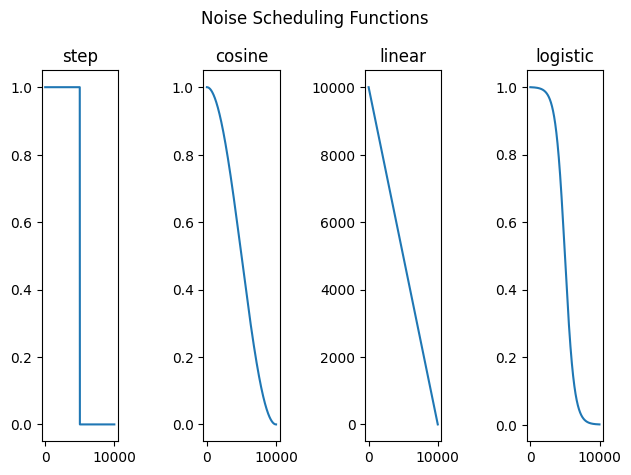

In [17]:
model_names = ['model_step.pth','model_linear.pth','model_cosine.pth','model_logistic.pth']
total_steps =10_000
noise_schedules = {
    'step': lambda t:1-np.round((t /total_steps)), # Step,
    'cosine': lambda t: 1 * (1 + np.cos(t/(total_steps)*np.pi))/2,  # Cosine
    'linear': lambda t: 1*(total_steps-t),  # Linear
    'logistic': lambda t: 1 / (1 + np.exp(15 * (t / total_steps - 0.5)))  # Logistic
}

fig, ax = plt.subplots(1,4)
fig.suptitle("Noise Scheduling Functions")
for i, k in enumerate(noise_schedules.keys()):
  x = np.arange(total_steps)
  y = noise_schedules[k](x)
  ax[i].plot(x,y)
  ax[i].set_title(f"{k}")
plt.tight_layout()

# Linear Noise Schedule
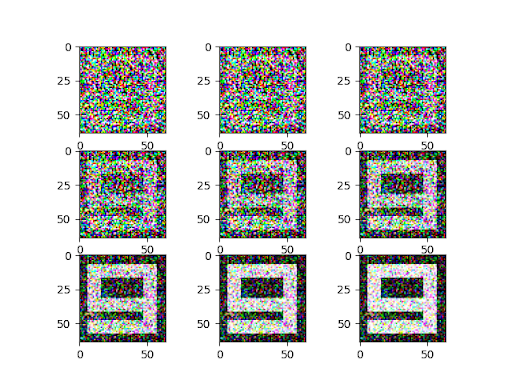

# Cosine Noise Schedule
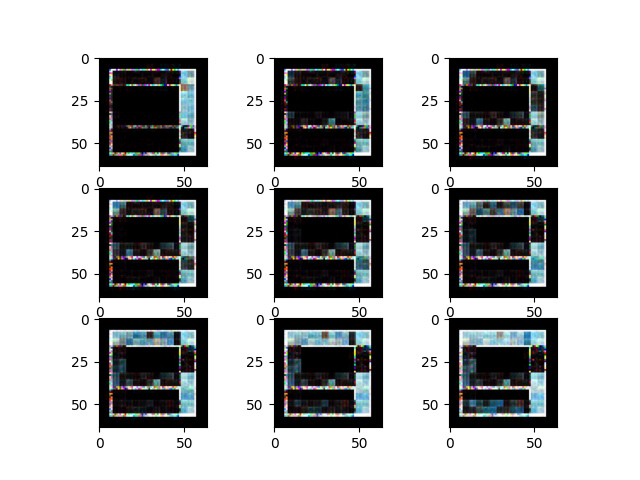

# Step Noise Schedule
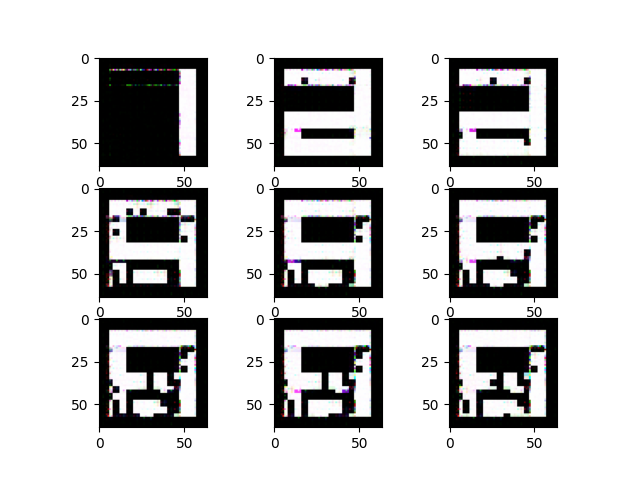

# Logistic Noise Schedule
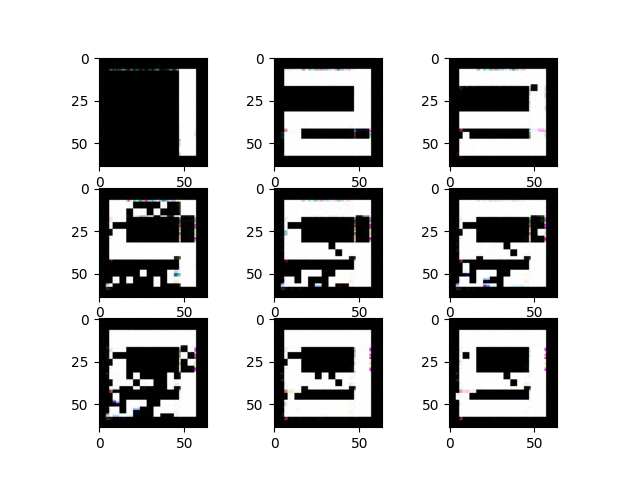

## Language Model Component and End-End Training

In [18]:
class NumberTokenizer:
    def __init__(self):
        # Define vocabulary: digits 0-9, plus special tokens
        self.vocab = ['<PAD>', '<SOS>', '<EOS>', '<SOI>'] + [str(i) for i in range(10)]
        self.char_to_idx = {char: idx for idx, char in enumerate(self.vocab)}
        self.idx_to_char = {idx: char for idx, char in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        self.pad_idx = self.char_to_idx['<PAD>']
        self.sos_idx = self.char_to_idx['<SOS>']
        self.eos_idx = self.char_to_idx['<EOS>']
        self.soi_idx = self.char_to_idx['<SOI>']

    def encode(self, text: str, end_token: int = None) -> torch.Tensor:
        # Convert string of numbers to token indices
        text_parts = text.split('<PAD>')
        tokens = []
        for part in text_parts:
            if len(tokens) > 0:
                tokens.append(self.pad_idx)
            tokens.extend(self.char_to_idx[c] for c in part)
        tokens = [self.sos_idx] + tokens
        if end_token is not None:
            tokens.append(end_token)
        return torch.tensor(tokens)

    def decode(self, tokens: torch.Tensor) -> str:
        # Convert token indices back to string
        chars = [self.idx_to_char[t.item()] for t in tokens]
        # Remove special tokens and join
        chars = [c for c in chars if c not in ['<PAD>', '<SOS>', '<EOS>']]
        return ''.join(chars)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int=128):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class NumberTransformer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int=128, nhead:int =8, num_layers:int=8, dim_feedforward:int=512, dropout:float=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers, norm=nn.LayerNorm(d_model))

        self.text_out = nn.Linear(d_model, vocab_size)
        self.img_out = nn.Linear(d_model, out_features=256)
        self.d_model = d_model

    def encode_text_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        tokens = self.embedding(tokens) * math.sqrt(self.d_model)
        return tokens

    def forward(self, tgt: torch.Tensor, tgt_mask=None, tgt_key_padding_mask=None):
        # tgt should already be encoded
        tgt = self.pos_encoder(tgt)

        # Create memory of same shape as target (since we're using decoder-only architecture)
        memory = torch.zeros_like(tgt)

        output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask,
                                       tgt_key_padding_mask=tgt_key_padding_mask)
        return self.text_out(output), self.img_out(output)

    def generate_text(self, flow: nf.NormalizingFlow, tokenizer, img: torch.Tensor):
        """Generate one text token"""
        self.eval()
        with torch.no_grad():
            z, log_det = flow.inverse_and_log_det(img)
            z = z.reshape(z.size(0), -1, self.d_model)
            # Encode start sequence
            current_seq = self.encode_text_tokens(torch.Tensor([tokenizer.sos_idx]).to(torch.int64).unsqueeze(0).cuda())  # Add batch dimension
            current_seq = torch.cat([z, current_seq], dim=1)

            # Create attention mask
            seq_len = current_seq.size(1)
            tgt_mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)

            # Get model predictions
            logits = self(current_seq, tgt_mask=tgt_mask)[0]
            next_token_logits = logits[0, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1)

        return tokenizer.decode([next_token])

    def generate_image(self, flow: nf.NormalizingFlow, text: str, tokenizer):
        """Generate an image conditioned on text using the flow model."""
        self.eval()
        with torch.no_grad():
            # Encode text sequence
            text_tokens = tokenizer.encode(text, end_token=tokenizer.soi_idx).unsqueeze(0).cuda()  # Add batch dimension
            text_embeddings = self.encode_text_tokens(text_tokens)

            z = torch.zeros(1, 16*16*3).cuda()
            offset = 0
            # Get model predictions
            for i in range(6):
                tgt_mask = torch.triu(torch.ones(text_embeddings.size(1), text_embeddings.size(1)) * float('-inf'), diagonal=1).cuda()
                logits = self(text_embeddings, tgt_mask=tgt_mask)[1]

                z_dist = logits[0, -1, :].view(1, -1, 2)  # Reshape to match flow dimensions
                locs = z_dist[:, :, 0]
                scales = z_dist[:, :, 1].exp()
                new_vals = locs + scales * torch.randn_like(locs)
                z[:, offset:offset+new_vals.size(1)] = new_vals
                offset += new_vals.size(1)

                text_embeddings = torch.cat([text_embeddings, new_vals.unsqueeze(1)], dim=1)

            # Generate image using flow
            image = flow.forward(z.reshape(1, 3, 16, 16))
            image = torch.clamp(image, min=0, max=255).to(torch.uint8)
            return image

def train_step(model: NumberTransformer, flow: nf.NormalizingFlow, optimizer, text, img, tokenizer: NumberTokenizer, criterion):
    optimizer.zero_grad()

    img_first = torch.randint(0, 2, (img.shape[0],), device=img.device) == 0

    # Img tokens
    z, log_det = flow.inverse_and_log_det(img)  # z has shape (batch_size, 3, 16, 16)
    z_tokens = z.reshape(z.size(0), -1, model.d_model)

    # Create target mask
    start_img_token = torch.Tensor([tokenizer.soi_idx]).cuda().unsqueeze(0).repeat(img.shape[0], 1).to(torch.int64)
    start_text_token = torch.Tensor([tokenizer.sos_idx]).cuda().unsqueeze(0).repeat(img.shape[0], 1).to(torch.int64)
    img_tokens = torch.cat([model.encode_text_tokens(torch.cat([text, start_img_token], dim=1)), z_tokens], dim=1)[~img_first]
    text_tokens = torch.cat([z_tokens, model.encode_text_tokens(start_text_token)], dim=1)[img_first]

    # Forward pass for imgs
    seq_len = img_tokens.size(1)
    tgt_mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).cuda()
    _, img_outputs = model(img_tokens, tgt_mask=tgt_mask)

    # Forward pass for texts
    seq_len = text_tokens.size(1)
    tgt_mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).cuda()
    text_outputs, _ = model(text_tokens, tgt_mask=tgt_mask)

    # Calculate loss (ignore padding tokens)
    text_loss = criterion(text_outputs[:, -1, :],
                    text[img_first, 1])

    pred_gaussians= img_outputs[:, -z_tokens.size(1):, :].reshape((~img_first).sum(), -1, 2)  # we now have a list of diagonal gaussians, one for each channel
    pred_logprob = -torch.distributions.Normal(pred_gaussians[:, :, 0],
                                                pred_gaussians[:, :, 1].exp()).log_prob(z[~img_first].flatten(start_dim=1)).mean()
    img_logprob = -torch.mean(log_det) * 0.0001
    img_loss = img_logprob + pred_logprob

    # Backward pass
    loss = text_loss + img_loss
    loss.backward()
    optimizer.step()

    return img_logprob.item(), pred_logprob.item(), text_loss.item()

def train_model(dataset: DataLoader, num_epochs: int=1):
    tokenizer = NumberTokenizer()
    model = NumberTransformer(vocab_size=tokenizer.vocab_size, num_layers=16).cuda()
    model = torch.compile(model)
    image_height, image_width = 16, 16
    flow = make_flow_model(image_width=image_width, image_height=image_height, num_layers=16, patch_size=4).cuda()
    flow = torch.compile(flow)
    optimizer = torch.optim.AdamW([{'params': model.parameters(), 'lr': 1e-4}, {'params': flow.parameters(), 'lr': 5e-3}], weight_decay=1e-5, betas=(0.9, 0.95))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_idx)

    for epoch in range(num_epochs):
        with tqdm(dataset, desc=f"Epoch {epoch}") as tp:
            for batch in tp:
                X, Y = batch  # Y is a list of sequences
                X = (X + torch.rand_like(X)).cuda()
                max_length = max(len(seq) for seq in Y)
                Y = torch.stack([tokenizer.encode(seq + '<PAD>' * (max_length - len(seq))) for seq in Y]).cuda()
                i_step_loss, pi_step_loss, t_step_loss = train_step(model, flow, optimizer, Y, X, tokenizer, criterion)
                tp.set_postfix(i_loss=i_step_loss, pi_loss=pi_step_loss, t_loss=t_step_loss)
        scheduler.step()
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(10):
            row = i // 5
            col = i % 5
            img = model.generate_image(flow, str(i), tokenizer).cpu().numpy()[0]
            axes[row, col].imshow(img.transpose(1, 2, 0))
            axes[row, col].set_title(f"Generated image for number {i}")
        plt.tight_layout()
        plt.show()

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(10):
            row = i // 5
            col = i % 5
            seq = model.generate_text(flow, tokenizer, X[i].unsqueeze(0).cuda())
            axes[row, col].imshow(torch.clamp(X[i].cpu(), min=0, max=255).numpy().transpose(1, 2, 0).astype(np.uint8))
            axes[row, col].set_title(f"Generated text for image {i}: {seq}")
        plt.tight_layout()
        plt.show()
    return model, flow, tokenizer

In [19]:
text_dataset = create_number_image_dataloader(num_samples=500_000, batch_size=512, min_length=1, max_length=1, image_width=16, image_height=16)

In [20]:
num_epochs = 40
tokenizer = NumberTokenizer()
model = NumberTransformer(vocab_size=tokenizer.vocab_size, num_layers=16).cuda()
model = torch.compile(model)
image_height, image_width = 16, 16
flow = make_flow_model(image_width=image_width, image_height=image_height, num_layers=16, patch_size=4).cuda()
flow = torch.compile(flow)
optimizer = torch.optim.AdamW([{'params': model.parameters(), 'lr': 1e-4}, {'params': flow.parameters(), 'lr': 5e-3}], weight_decay=1e-5, betas=(0.9, 0.95))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_idx)

for epoch in range(num_epochs):
    with tqdm(text_dataset, desc=f"Epoch {epoch}") as tp:
        for batch in tp:
            X, Y = batch  # Y is a list of sequences
            X = (X + torch.rand_like(X)).cuda()
            max_length = max(len(seq) for seq in Y)
            Y = torch.stack([tokenizer.encode(seq) for seq in Y]).cuda()
            i_step_loss, pi_step_loss, t_step_loss = train_step(model, flow, optimizer, Y, X, tokenizer, criterion)
            tp.set_postfix(i_loss=i_step_loss, pi_loss=pi_step_loss, t_loss=t_step_loss)
    scheduler.step()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        row = i // 5
        col = i % 5
        img = model.generate_image(flow, str(i), tokenizer).cpu().numpy()[0]
        axes[row, col].imshow(img.transpose(1, 2, 0))
        axes[row, col].set_title(f"Generated image for number {i}")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        row = i // 5
        col = i % 5
        seq = model.generate_text(flow, tokenizer, X[i].unsqueeze(0).cuda())
        axes[row, col].imshow(torch.clamp(X[i].cpu(), min=0, max=255).numpy().transpose(1, 2, 0).astype(np.uint8))
        axes[row, col].set_title(f"Generated text for image {i}: {seq}")
    plt.tight_layout()
    plt.show()

Epoch 0:   0%|          | 0/977 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'model.pth')
torch.save(flow, 'flow.pth')
torch.save(tokenizer, 'tokenizer.pth')

## Evaluating End-End Model

In [21]:
model = torch.load('model.pth', weights_only=False)
flow = torch.load('flow.pth', weights_only=False)
tokenizer = torch.load('tokenizer.pth', weights_only=False)

Image-Text

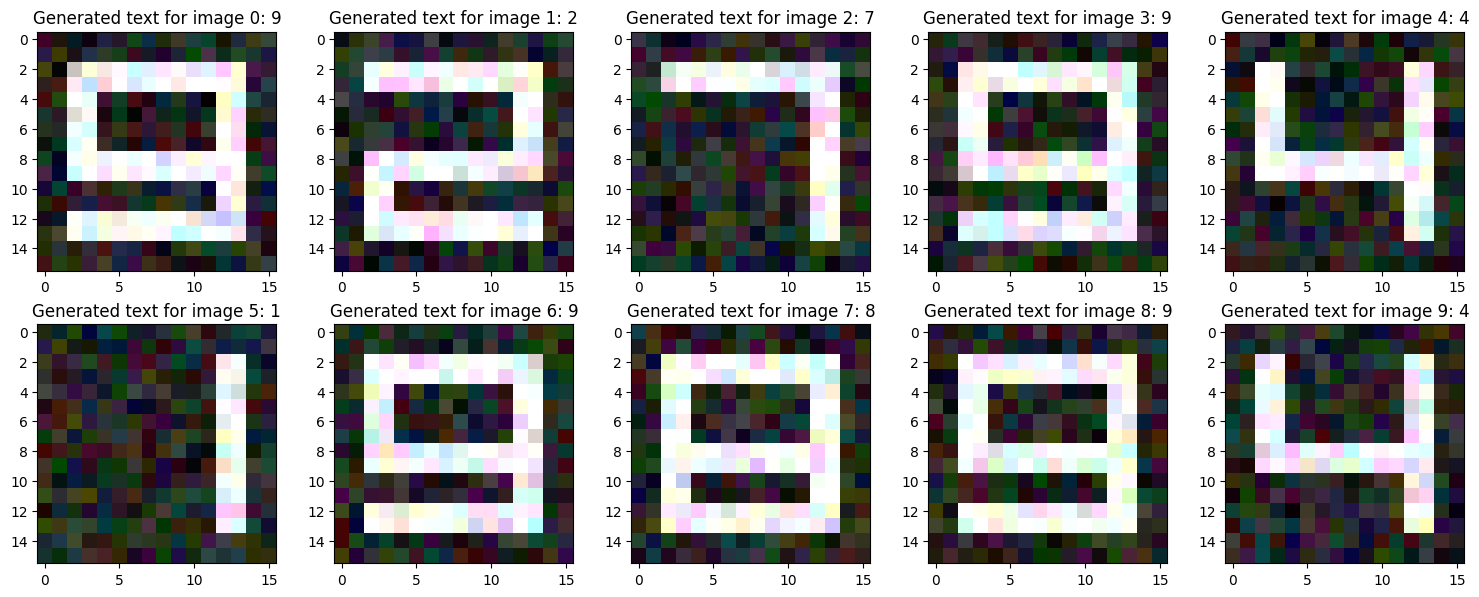

In [22]:
# @title
X, _ = next(iter(text_dataset))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    seq = model.generate_text(flow, tokenizer, X[i].unsqueeze(0).cuda())
    axes[row, col].imshow(torch.clamp(X[i].cpu(), min=0, max=255).numpy().transpose(1, 2, 0).astype(np.uint8))
    axes[row, col].set_title(f"Generated text for image {i}: {seq}")
plt.tight_layout()
plt.show()

Text-Image

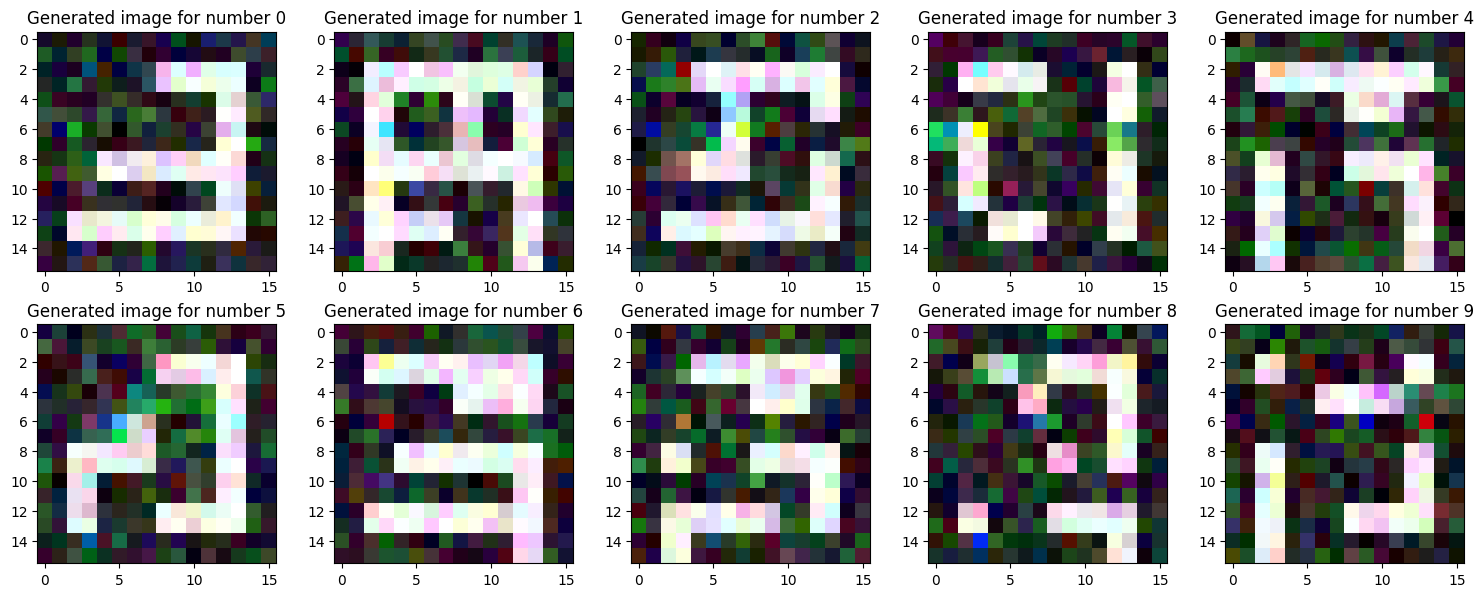

In [58]:
# @title
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    img = model.generate_image(flow, str(i), tokenizer).cpu().numpy()[0]
    axes[row, col].imshow(img.transpose(1, 2, 0))
    axes[row, col].set_title(f"Generated image for number {i}")
plt.tight_layout()
plt.show()